In [134]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
from IPython import get_ipython
from sklearn import tree, metrics
from sklearn.metrics import recall_score,precision_score,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Data-processing

In [179]:
project_path = "C:\\Users\\jaide\\DSA Project"
os.chdir(project_path)
os.getcwd()

'C:\\Users\\jaide\\DSA Project'

In [180]:
crime_data=pd.read_csv(os.getcwd()+ '\\Crime Prediction Data\\communities-crime-clean.csv')
#print(crime_data.head())
crime_data.shape

(1993, 104)

In [181]:
nanrows=crime_data[crime_data.isnull().T.any().T]
nanrows.shape

(0, 104)

In [182]:
crime_data.columns

Index(['state', 'communityname', 'fold', 'population', 'householdsize',
       'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp',
       'agePct12t21',
       ...
       'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85',
       'PctSameState85', 'LandArea', 'PopDens', 'PctUsePubTrans',
       'LemasPctOfficDrugUn', 'ViolentCrimesPerPop'],
      dtype='object', length=104)

** Create the variable highCrime to be used in our classification models. **

# 1. a)

In [183]:
print(crime_data.ViolentCrimesPerPop.dtype)

crime_data["highCrime"]=[True if i>0.1 else False for i in crime_data.ViolentCrimesPerPop]

print(crime_data.shape)
print(crime_data["highCrime"].head())


float64
(1993, 105)
0    False
1     True
2     True
3     True
4     True
Name: highCrime, dtype: bool


** Check the distribution of the boolean category highCrime. (Should be reasonably split between 50-50 to 80-20) **

In [184]:
print(crime_data["highCrime"].dtype)

v=crime_data["highCrime"].value_counts(normalize=True)*100

#v=(v/sum(v))*100

print("Percentage of high crimes(True) :\n",v)

bool
Percentage of high crimes(True) :
 True     62.719518
False    37.280482
Name: highCrime, dtype: float64


** We need to create dummy variables for the string categorical variable community to successfully use it in the predictive models. **

In [185]:
y_train=crime_data["highCrime"]
x_train=crime_data.drop(["highCrime","ViolentCrimesPerPop"],axis=1)
print(y_train.head())
print(x_train.shape)

x2=x_train.drop("communityname",axis=1)
df_with_dummies= pd.get_dummies(x_train,columns=["communityname"],drop_first=False)
df_with_dummies

0    False
1     True
2     True
3     True
4     True
Name: highCrime, dtype: bool
(1993, 103)


,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,communityname_Yeadonborough,communityname_Yonkerscity,communityname_YorbaLindacity,communityname_Yorktownship,communityname_Yorktowntown,communityname_Youngstowncity,communityname_YubaCitycity,communityname_Yucaipacity,communityname_Yukoncity,communityname_Zanesvillecity
0,1,7,0.01,0.61,0.21,0.83,0.02,0.01,0.41,0.49,...,0,0,0,0,0,0,0,0,0,0
1,1,10,0.01,0.41,0.55,0.57,0.01,0.00,0.47,0.45,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0.03,0.34,0.86,0.30,0.04,0.01,0.41,0.42,...,0,0,0,0,0,0,0,0,0,0
3,1,8,0.01,0.38,0.35,0.71,0.04,0.01,0.39,0.46,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0.04,0.37,0.32,0.70,0.21,0.02,1.00,1.00,...,0,0,0,0,0,0,0,0,0,0
5,1,6,0.04,0.44,1.00,0.10,0.00,0.00,0.43,0.45,...,0,0,0,0,0,0,0,0,0,0
6,1,2,0.41,0.37,1.00,0.02,0.03,0.01,0.41,0.50,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0.01,0.30,0.00,0.99,0.02,0.01,0.38,0.37,...,0,0,0,0,0,0,0,0,0,0
8,1,7,0.00,0.39,0.31,0.75,0.02,0.02,0.35,0.43,...,0,0,0,0,0,0,0,0,0,0
9,1,10,0.06,0.39,0.32,0.73,0.04,0.01,0.39,0.46,...,0,0,0,0,0,0,0,0,0,0


# 1.b) Decision Tree Classifier

In [186]:
n=4
k=18

clf=tree.DecisionTreeClassifier(max_depth=n, max_leaf_nodes=k)
clf=clf.fit(df_with_dummies,y_train)
y_pred=clf.predict(df_with_dummies)
#        print("Decision tree built. Calculating accuracy\n")
accuracy = pd.DataFrame(columns=['Depth', 'Leaf', 'Accuracy'])
acu=metrics.accuracy_score(y_train, y_pred)
rec=recall_score(y_train,y_pred,average=None)
pre=precision_score(y_train,y_pred,average=None)
accuracy=accuracy.append([{'Depth':n,'Leaf':k,'Accuracy':acu,'Recall Score': rec, 'Precision Score': pre}])

#classes=pd.Series(clf.classes_)
#c2=classes.map({True: "T", False: "F"})

accuracy.sort_values(by=['Accuracy'], ascending = False)

cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
cross_fold.Precision=cross_val_score(clf,df_with_dummies,y_train,cv=10,scoring='precision')

cross_fold.Recall=cross_val_score(clf,df_with_dummies,y_train,cv=10,scoring='recall')
cross_fold.Accuracy=cross_val_score(clf,df_with_dummies,y_train,cv=10)
print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))

cross_fold



Mean Precision ::0.8262317198953643
Mean Recall::0.8151999999999999
Mean Accuracy::0.7656683417085427


,Precision,Recall,Accuracy
0,0.683060,1.000,0.710000
1,0.776316,0.944,0.795000
2,0.818841,0.904,0.815000
3,0.859375,0.880,0.834171
4,0.815534,0.672,0.698492
5,0.846939,0.664,0.713568
6,0.810219,0.872,0.798995
7,0.951807,0.632,0.748744
8,0.789116,0.928,0.798995
9,0.911111,0.656,0.743719


** Through multiple iterations (trial and error) it was found the model works best with max leaf nodes as 18 and depth as 4.This has been ommitted since it leads to redundancy. **

# 1.b) i), 1. c) i)

In [187]:
n=4
k=18
accuracy = pd.DataFrame(columns=['Depth', 'Leaf', 'Accuracy'])
clf2=tree.DecisionTreeClassifier(max_depth=n, max_leaf_nodes=k)
clf2=clf2.fit(x2,y_train)
#        print("Decision tree built. Calculating accuracy\n")
acu=metrics.accuracy_score(y_train, clf2.predict(x2))
print (n, " ",k, " ",acu)
accuracy=accuracy.append([{'Depth':n,'Leaf':k,'Accuracy':acu}])


accuracy.sort_values(by=['Accuracy'], ascending = False)

classes=pd.Series(clf2.classes_)

#print(type(classes))
c2=classes.map({True: "T", False: "F"})

#print(c2)

cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
cross_fold.Precision=cross_val_score(clf2,x2,y_train,cv=10,scoring='precision')

cross_fold.Recall=cross_val_score(clf2,x2,y_train,cv=10,scoring='recall')
cross_fold.Accuracy=cross_val_score(clf2,x2,y_train,cv=10)
print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))

cross_fold



4   18   0.858003010537
Mean Precision ::0.8237593766167854
Mean Recall::0.8183999999999999
Mean Accuracy::0.7621633165829146


,Precision,Recall,Accuracy
0,0.683060,1.000,0.710000
1,0.751592,0.960,0.770000
2,0.818841,0.904,0.815000
3,0.859375,0.880,0.834171
4,0.815534,0.672,0.698492
5,0.846939,0.664,0.713568
6,0.810219,0.888,0.788945
7,0.951807,0.632,0.748744
8,0.789116,0.928,0.798995
9,0.911111,0.656,0.743719


** Since by comparing the above two decision tree models, we can see that creating dummy variables for community does not create too much difference as compared to dropping the feature. By avoiding the dummy variables for each value in community we save ourselves from creating a dataset much too complex.To confirm this logic, we shall do the same comparison in some other model as well**

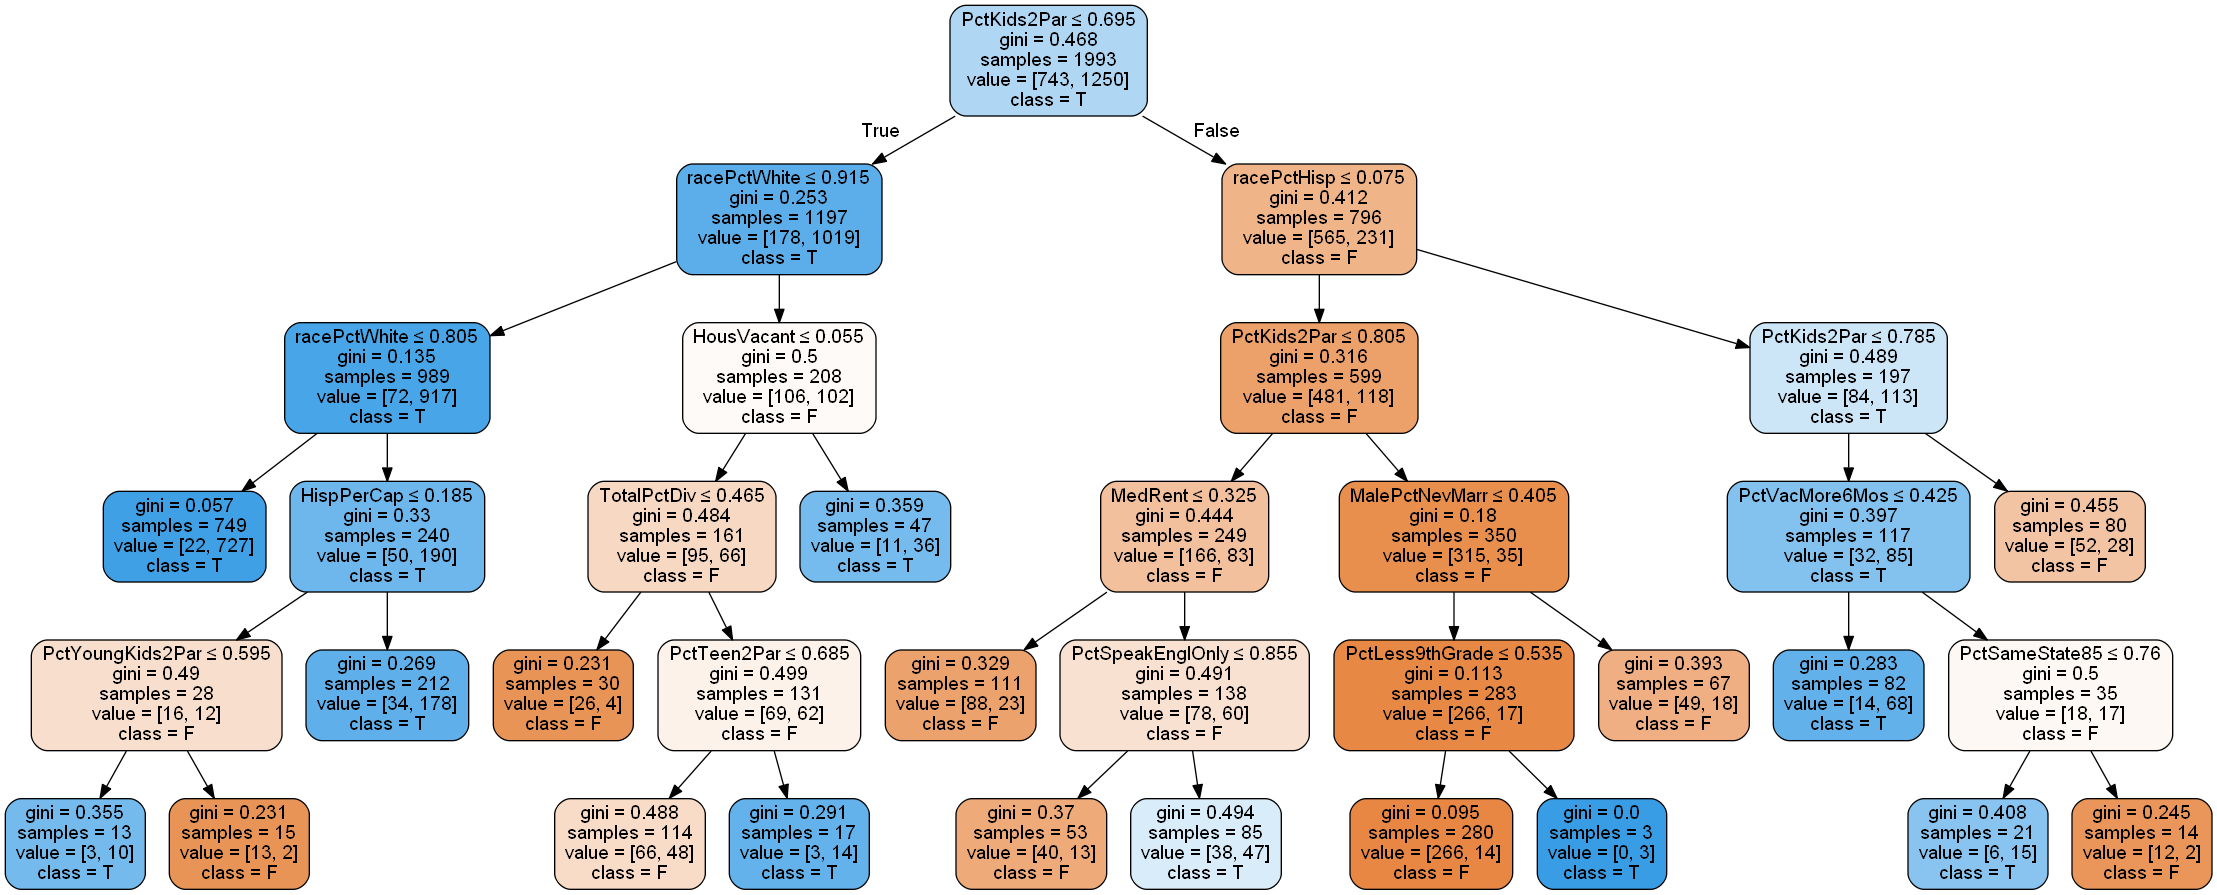

In [188]:
#Creating a png for the best decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = StringIO()
export_graphviz(clf2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=x2.columns,
                class_names=c2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [145]:
cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
cross_fold.Precision=cross_val_score(clf,df_with_dummies,y_train,cv=10,scoring='precision')

cross_fold.Recall=cross_val_score(clf,df_with_dummies,y_train,cv=10,scoring='recall')
cross_fold.Accuracy=cross_val_score(clf,df_with_dummies,y_train,cv=10)
print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))

cross_fold

Mean Precision ::0.8260194957867053
Mean Recall::0.8168
Mean Accuracy::0.7651633165829146


,Precision,Recall,Accuracy
0,0.683060,1.000,0.710000
1,0.774194,0.944,0.800000
2,0.818841,0.904,0.815000
3,0.859375,0.880,0.834171
4,0.815534,0.672,0.698492
5,0.846939,0.664,0.713568
6,0.810219,0.888,0.788945
7,0.951807,0.632,0.748744
8,0.789116,0.928,0.798995
9,0.911111,0.656,0.743719


# 1.c) ii)
** The cross validation results differ from the results on the entire dataset, since a 10-fold CV measures the model performance from out-of-sample data and is thus more robust to overfitting and a better indicator for performance.**

# 1.b ii)

In [189]:
c=pd.DataFrame({'Name':x2.columns,'Value':clf2.feature_importances_})
print(c.sort_values(by='Value', ascending=False).head(15))

                Name     Value
46       PctKids2Par  0.638749
5       racePctWhite  0.149325
7        racePctHisp  0.081314
73        HousVacant  0.017833
28        HispPerCap  0.016161
87           MedRent  0.012321
62  PctSpeakEnglOnly  0.011950
77    PctVacMore6Mos  0.011197
43       TotalPctDiv  0.010909
47  PctYoungKids2Par  0.010891
97    PctSameState85  0.010607
31   PctLess9thGrade  0.010360
48       PctTeen2Par  0.009268
41    MalePctNevMarr  0.009115
69   PctPersOwnOccup  0.000000


** Features like PctKids2Par and HousVacant make sense to be the highest indicators of crime since localities with families and kids are more likely to be targeted by criminals. Also, Vacant houses would suggest the area does not attract people to settle down which could be due to high crime. **

# 2. a) Naive Bayes

In [147]:
gnb = GaussianNB()
gnb = gnb.fit(df_with_dummies, y_train)
y_pred=gnb.predict(df_with_dummies)
accuracy = pd.DataFrame(columns=[ 'Accuracy'])
acu=metrics.accuracy_score(y_train, y_pred)
rec=recall_score(y_train,y_pred,average=None)
pre=precision_score(y_train,y_pred,average=None)
accuracy=accuracy.append([{'Accuracy':acu,'Recall Score': rec, 'Precision Score': pre}])
accuracy.sort_values(by=['Accuracy'], ascending = False)

,Accuracy,Precision Score,Recall Score
0,0.966884,"[0.918417799753, 1.0]","[1.0, 0.9472]"


In [148]:
cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
cross_fold.Precision=cross_val_score(gnb,df_with_dummies,y_train,cv=10,scoring='precision')

cross_fold.Recall=cross_val_score(gnb,df_with_dummies,y_train,cv=10,scoring='recall')
cross_fold.Accuracy=cross_val_score(gnb,df_with_dummies,y_train,cv=10)
print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))

cross_fold

Mean Precision ::0.8273227481053569
Mean Recall::0.1624
Mean Accuracy::0.4531105527638191


,Precision,Recall,Accuracy
0,0.791667,0.152,0.445000
1,0.615385,0.128,0.405000
2,0.869565,0.160,0.460000
3,0.800000,0.160,0.447236
4,0.954545,0.168,0.472362
5,0.730769,0.152,0.432161
6,0.875000,0.168,0.462312
7,0.962963,0.208,0.497487
8,0.840000,0.168,0.457286
9,0.833333,0.160,0.452261


**The Model performance suggests a serious problem. This could probably be because of probability assignments for each 
of the 1929 features becomes too small. the features have increased because we made a new column for each value of community.**

In [149]:
gnb2 = GaussianNB()
gnb2 = gnb2.fit(x2, y_train)
y_pred=gnb2.predict(x2)
accuracy = pd.DataFrame(columns=[ 'Accuracy'])
acu=metrics.accuracy_score(y_train, y_pred)
rec=recall_score(y_train,y_pred,average=None)
pre=precision_score(y_train,y_pred,average=None)
accuracy=accuracy.append([{'Accuracy':acu,'Recall Score': rec, 'Precision Score': pre}])
accuracy.sort_values(by=['Accuracy'], ascending = False)

,Accuracy,Precision Score,Recall Score
0,0.776719,"[0.640566037736, 0.931404072883]","[0.913862718708, 0.6952]"


**As you can see the Accuracy is in an acceptable range now by dropping the community feature and not using dummy features.**

# 2. a) i)

In [150]:
cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
cross_fold.Precision=cross_val_score(gnb2,x2,y_train,cv=10,scoring='precision')

cross_fold.Recall=cross_val_score(gnb2,x2,y_train,cv=10,scoring='recall')
cross_fold.Accuracy=cross_val_score(gnb2,x2,y_train,cv=10)
print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))

cross_fold

Mean Precision ::0.9124193091042139
Mean Recall::0.6975999999999999
Mean Accuracy::0.7651080402010051


,Precision,Recall,Accuracy
0,0.867257,0.784,0.790000
1,0.931373,0.760,0.815000
2,0.950495,0.768,0.830000
3,0.920792,0.744,0.798995
4,0.945946,0.560,0.703518
5,0.868421,0.528,0.653266
6,0.923077,0.768,0.814070
7,1.000000,0.576,0.733668
8,0.778689,0.760,0.713568
9,0.938144,0.728,0.798995


In [151]:
x2.columns[46]

'PctKids2Par'

# 2. a) ii)

In [152]:
means=pd.DataFrame(columns=['Feature','diff_abs_mean','diff_var'])
diff=[]
ad=[]
for i in range(0,gnb2.theta_.shape[1]):
    diff.append(abs(gnb2.theta_[0,i]-gnb2.theta_[1,i]))
    ad.append(gnb2.sigma_[0,i]+gnb2.sigma_[1,i])
    means=means.append([{'Feature': x2.columns[i],'diff_abs_mean': abs(gnb2.theta_[0,i]-gnb2.theta_[1,i]), 'diff_var': gnb2.sigma_[0,i]+gnb2.sigma_[1,i]}])
means['weight']=means.diff_abs_mean/means.diff_var
means=means.reset_index()
means=means.drop(['index','diff_abs_mean','diff_var'],1)
means.sort_values(by=['weight'], ascending = False).head(10)

,Feature,weight
46,PctKids2Par,5.001257
42,FemalePctDiv,4.756826
45,PctFam2Par,4.593940
17,pctWInvInc,4.394939
43,TotalPctDiv,4.385936
48,PctTeen2Par,3.999311
40,MalePctDivorce,3.950688
47,PctYoungKids2Par,3.648270
52,PctIlleg,3.469861
5,racePctWhite,3.443203


** Features like PctKids2Par and PctFam2Par make sense to be the highest indicators of crime since localities with families and kids are more likely to be targeted by criminals.  **

# 2. a) iii)
**The Naive bayes results are slightly different from the decision tree classifier . The top features are slightly different from the decision tree, probably due to the difference in the model assumptions. However, The Recall of Decision trees is much better. **

# 2.b) Linear SVC

In [153]:
svc= LinearSVC(random_state=0)
svc = svc.fit(df_with_dummies, y_train)
y_pred_svc=svc.predict(df_with_dummies)

cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
cross_fold.Precision=cross_val_score(svc,df_with_dummies,y_train,cv=10,scoring='precision')

cross_fold.Recall=cross_val_score(gnb2,df_with_dummies,y_train,cv=10,scoring='recall')
cross_fold.Accuracy=cross_val_score(gnb2,df_with_dummies,y_train,cv=10)
print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))
cross_fold

Mean Precision ::0.8532455293738268
Mean Recall::0.1624
Mean Accuracy::0.4531105527638191


,Precision,Recall,Accuracy
0,0.730539,0.152,0.445000
1,0.767296,0.128,0.405000
2,0.863636,0.160,0.460000
3,0.868852,0.160,0.447236
4,0.870588,0.168,0.472362
5,0.901235,0.152,0.432161
6,0.877049,0.168,0.462312
7,0.951456,0.208,0.497487
8,0.802721,0.168,0.457286
9,0.899083,0.160,0.452261


# 2.b)i)

In [154]:
svc= LinearSVC(random_state=0)
svc = svc.fit(x2, y_train)
y_pred_svc=svc.predict(x2)

cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
cross_fold.Precision=cross_val_score(svc,x2,y_train,cv=10,scoring='precision')

cross_fold.Recall=cross_val_score(svc,x2,y_train,cv=10,scoring='recall')
cross_fold.Accuracy=cross_val_score(svc,x2,y_train,cv=10)
print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))
cross_fold

Mean Precision ::0.8258781974433582
Mean Recall::0.8136000000000001
Mean Accuracy::0.7404597989949748


,Precision,Recall,Accuracy
0,0.715116,0.984,0.745000
1,0.906250,0.928,0.895000
2,0.845588,0.920,0.845000
3,0.758389,0.904,0.758794
4,0.967213,0.472,0.658291
5,0.700000,0.896,0.693467
6,0.731707,0.960,0.753769
7,1.000000,0.544,0.713568
8,0.634518,1.000,0.638191
9,1.000000,0.528,0.703518


# 2.b).ii)

In [155]:
svc_features=pd.DataFrame(columns=['Feature','coefficient'])
svc_features.Feature=x2.columns

svc_features.coefficient=svc.coef_.ravel()
svc_features.coefficient=svc_features.coefficient.abs()
svc_features.sort_values(by=['coefficient'], ascending = False).head(10)

,Feature,coefficient
17,pctWInvInc,1.751083
5,racePctWhite,1.133042
46,PctKids2Par,1.010878
66,PersPerOccupHous,0.918995
86,RentHighQ,0.880651
7,racePctHisp,0.856792
40,MalePctDivorce,0.852156
8,agePct12t21,0.828483
73,HousVacant,0.786849
70,PctPersDenseHous,0.765661


# 2.b) iii)
Between the two models, the decision tree is clearly able to learn with dummy variables encoded for categorical variables 
while linear svc is not. Between the two, the have very similar Precicion and Accuracy values but the Accuracy for
Decision trees is much higher (76) as  compared to LinearSVC (74). Thus a decision tree algorithm, although complex,
would have a better set of predictions.

# 3. a) Linear Regression

In [156]:
y_train=crime_data["ViolentCrimesPerPop"]

In [157]:
lm= LinearRegression(fit_intercept=True)
#lm=lm.fit(x2,y_train)
#cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
#cross_fold.Precision=
#cross_val_score(lm,x2,y_train,cv=10,scoring='precision')

#cross_fold.Recall=cross_val_score(lm,x2,y_train,cv=10,scoring='recall')
#cross_fold.Accuracy=
cross_val_score(lm,df_with_dummies,y_train,cv=10,scoring='neg_mean_squared_error')
#print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
#print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
#print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))
#cross_fold

array([-0.32149408, -0.18549202, -0.17871353, -0.22877461, -0.14700658,
       -0.11134696, -0.29789056, -0.1153689 , -0.14139862, -0.10900507])

# 3. a) i)

In [158]:
lm= LinearRegression(fit_intercept=True)
lm=lm.fit(x2,y_train)
cross_fold = pd.DataFrame(columns=['MSE'])
#cross_fold.Precision=
#cross_val_score(lm,x2,y_train,cv=10,scoring='precision')

#cross_fold.Recall=cross_val_score(lm,x2,y_train,cv=10,scoring='recall')
cross_fold.MSE=cross_val_score(lm,x2,y_train,cv=10,scoring='neg_mean_squared_error')
print("Mean MSE::{p}".format(p=cross_fold.MSE.abs().mean()))
#print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
#print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
#print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))
cross_fold.abs()

Mean MSE::0.01990784631391438


,MSE
0,0.029604
1,0.019958
2,0.027061
3,0.023325
4,0.019061
5,0.012519
6,0.018210
7,0.012218
8,0.022117
9,0.015005


# 3. a) ii)

In [160]:
y_pred=lm.predict(x2)
print("MSE on entire dataset::{p}".format(p=mean_squared_error(y_train,y_pred)))

MSE on entire dataset::0.016419118572348866


# 3. a) iii)

In [161]:
lm_features=pd.DataFrame(columns=['Feature','coefficient','sign'])
lm_features.Feature=x2.columns

lm_features.coefficient=lm.coef_
lm_features.coefficient=lm_features.coefficient.abs()
lm_features.sign=np.sign(lm.coef_)
print("Top Features contributing to high crime rate:")
lm_features.loc[lm_features['sign'] == 1].sort_values(by=['coefficient'], ascending = False).head(5)

Top Features contributing to high crime rate:


,Feature,coefficient,sign
75,PctHousOwnOcc,0.574399,1.0
66,PersPerOccupHous,0.564192,1.0
40,MalePctDivorce,0.454779,1.0
60,PctRecImmig8,0.390671,1.0
87,MedRent,0.344240,1.0


In [162]:
print("Top Features contributing to low crime rate:")
lm_features.loc[lm_features['sign'] == -1].sort_values(by=['coefficient'], ascending = False).head(5)

Top Features contributing to low crime rate:


,Feature,coefficient,sign
69,PctPersOwnOccup,0.702546,-1.0
43,TotalPctDiv,0.537341,-1.0
81,OwnOccLowQuart,0.393367,-1.0
23,whitePerCap,0.350161,-1.0
46,PctKids2Par,0.284324,-1.0


# 3.b) Ridge Regression

# 3. b) i)

In [163]:
rr= RidgeCV(alphas=(10, 1, 0.1, 0.01,0.001),fit_intercept=True,cv=10)
rr=rr.fit(x2,y_train)

y_pred=rr.predict(x2)
print("10-fold MSE ::{p}".format(p=mean_squared_error(y_train,y_pred)))

10-fold MSE ::0.01741051378833569


# 3.b) ii)

In [164]:
rr= RidgeCV(alphas=(10, 1, 0.1, 0.01,0.001),fit_intercept=True)
rr=rr.fit(x2,y_train)

y_pred=rr.predict(x2)
print("MSE on the entire dataset ::{p}".format(p=mean_squared_error(y_train,y_pred)))

MSE on the entire dataset ::0.016653341203418992


# 3.b) iii)

In [165]:
print("Best alpha:{p}".format(p=rr.alpha_))

Best alpha:1.0


# 3.b) iv)
**A 10-Fold cross-validation gives a good estimate of the goodness of model over any scoring criteria since it iterates through different train-test splits thus reducing any unintended bias.
For the scoring criteria of Mean Square Error which gives us a good estimate to how far our model estimates are from the actual values, Ridge regression gives us a value of 0.0174 as compared to 0.02 of Linear Regression. A lesser MSE value over 10-folds is a good indicator that Ridge regression contributes in reducing model overfit as compared to Linear Regression.**

# 3. c) i)

In [166]:
poly = PolynomialFeatures(degree=2)
poly=poly.fit_transform(x2)
poly.shape

(1993, 5356)

In [167]:
lm= LinearRegression(fit_intercept=True)
lm=lm.fit(poly,y_train)
cross_fold = pd.DataFrame(columns=['MSE'])

cross_fold.MSE=cross_val_score(lm,poly,y_train,cv=10,scoring='neg_mean_squared_error')
print("Mean MSE::{p}".format(p=cross_fold.MSE.abs().mean()))
cross_fold.abs()

Mean MSE::0.14631306978060704


,MSE
0,0.206033
1,0.171748
2,0.254737
3,0.097788
4,0.091398
5,0.145974
6,0.086438
7,0.073953
8,0.203943
9,0.131118


# 3. c) ii)

In [168]:
y_pred=lm.predict(poly)
print("MSE on entire dataset::{p}".format(p=mean_squared_error(y_train,y_pred)))

MSE on entire dataset::2.7534380196155763e-25


# 3. c) iii)
** After a 10-fold CV, the Mean MSE of the quadratic model is 0.146 which is significantly greater than the Mean MSE of the linear model (0.02). Therefore the Linear model is better than the quadratic model.Even though the MSE on the entire data suggests otherwise, a 10-fold Cross Validation is always a better indicator in model performance.**

# 4. Decision Tree on Dirty Data (entire uncleaned dataset)

In [169]:
crime_data_full=pd.read_csv(os.getcwd()+ '\\Crime Prediction Data\\communities-crime-full.csv')

crime_data_full.shape

(1994, 128)

In [170]:
nanrows=crime_data_full[crime_data_full.isnull().T.any().T]
nanrows.shape

(0, 128)

In [171]:
crime_data_full.head(5)

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


**Replacing ? with Na**

In [172]:
crime_data_full=crime_data_full.replace('?',np.nan)
crime_data_full.head(5)

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [173]:
nanrows=crime_data_full[crime_data_full.isnull().T.any().T]
nanrows.shape

(1871, 128)

** Replace Na rows with median values**

In [174]:
crime_data_full=crime_data_full.drop(["communityname"],axis=1)
crime_data_full=crime_data_full.fillna(crime_data_full.median())
crime_data_full.shape

(1994, 127)

In [175]:
crime_data_full["highCrime"]=[True if i>0.1 else False for i in crime_data_full.ViolentCrimesPerPop]

print(crime_data_full.shape)
print(crime_data_full["highCrime"].head())

(1994, 128)
0     True
1     True
2     True
3     True
4    False
Name: highCrime, dtype: bool


In [176]:
print(crime_data_full["highCrime"].dtype)

v=crime_data_full["highCrime"].value_counts(normalize=True)*100

#v=(v/sum(v))*100

print("Percentage of high crimes(True) :\n",v)

bool
Percentage of high crimes(True) :
 True     62.738215
False    37.261785
Name: highCrime, dtype: float64


In [177]:
y_train_full=crime_data_full["highCrime"]
x_train_full=crime_data_full.drop(["highCrime","ViolentCrimesPerPop"],axis=1)
print(y_train_full.shape)
print(x_train_full.shape)



(1994,)
(1994, 126)


In [178]:
n=4
k=18
accuracy = pd.DataFrame(columns=['Depth', 'Leaf', 'Accuracy'])
clf2=tree.DecisionTreeClassifier(max_depth=n, max_leaf_nodes=k)
clf2=clf2.fit(x_train_full,y_train_full)
#        print("Decision tree built. Calculating accuracy\n")
acu=metrics.accuracy_score(y_train_full, clf2.predict(x_train_full))
print (n, " ",k, " ",acu)
accuracy=accuracy.append([{'Depth':n,'Leaf':k,'Accuracy':acu}])


accuracy.sort_values(by=['Accuracy'], ascending = False)

#classes=pd.Series(clf2.classes_)

#print(type(classes))
#c2=classes.map({True: "T", False: "F"})

#print(c2)

cross_fold = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'])
cross_fold.Precision=cross_val_score(clf2,x_train_full,y_train_full,cv=10,scoring='precision')

cross_fold.Recall=cross_val_score(clf2,x_train_full,y_train_full,cv=10,scoring='recall')
cross_fold.Accuracy=cross_val_score(clf2,x_train_full,y_train_full,cv=10)
print("Mean Precision ::{p}".format(p=cross_fold.Precision.mean()))
print("Mean Recall::{p}".format(p=cross_fold.Recall.mean()))
print("Mean Accuracy::{p}".format(p=cross_fold.Accuracy.mean()))

cross_fold

4   18   0.858074222668
Mean Precision ::0.8499423925221287
Mean Recall::0.8217079365079364
Mean Accuracy::0.7958483712092802


,Precision,Recall,Accuracy
0,0.858268,0.865079,0.825871
1,0.843750,0.864000,0.815000
2,0.844262,0.824000,0.795000
3,0.816794,0.856000,0.783920
4,0.868852,0.848000,0.824121
5,0.854545,0.752000,0.763819
6,0.878261,0.808000,0.809045
7,0.882883,0.784000,0.798995
8,0.864407,0.816000,0.804020
9,0.787402,0.800000,0.738693


# 4.a)
** After processing the data by including the median of the feature values in place of missing values, and then running a decision tree classifier on this new dataset, the following conclusions were found:
Missing value treatment of including medians in place of missing values is better than just blindly removing the columns with missing data for this dataset.
The Mean accuracy after a 10-fold CV on a Decision tree classifier increases from 76% in the first case to 79% with increases in Precision and Recall as well.**